## Timeseries

In many domains it is common to plot scalar values as a function of time (or other single dimensions).  As long as the total number of datapoints is relatively low (in the tens of thousands, perhaps) and there are only a few separate curves involved, most plotting packages will do well.  However, for longer or more frequent sampling, you'll be required to subsample your data before plotting, potentially missing important peaks or troughs in the data.  And even just a few timeseries visualized together quickly run into highly misleading [overplotting](https://anaconda.org/jbednar/plotting_problems/notebook) issues, making the most recently plotted curves unduly prominent.

For applications with many datapoints or when visualizing multiple curves, datashader provides a principled way to view *all* of your data.  In this example, we will synthesize several time-series curves so that we know their properties, and then show how datashader can reveal them.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
from collections import OrderedDict

### Create some fake timeseries data

Here we create a fake time series signal, then generate many noisy versions of it.  We will also add a couple of "rogue" lines, with different statistical properties, and see how well those stand out from the rest.

In [2]:
# Constants
np.random.seed(2)
n = 100000                           # Number of points
cols = list('abcdefg')               # Column names of samples
start = 1456297053                   # Start time
end = start + 60 * 60 * 24           # End time   

# Generate a fake signal
time = np.linspace(start, end, n)
signal = np.random.normal(0, 0.3, size=n).cumsum() + 50

# Generate many noisy samples from the signal
noise = lambda var, bias, n: np.random.normal(bias, var, n)
data = {c: signal + noise(1, 10*(np.random.random() - 0.5), n) for c in cols}

# Add some "rogue lines" that differ from the rest 
cols += ['x'] ; data['x'] = signal + np.random.normal(0, 0.02, size=n).cumsum() # Gradually diverges
cols += ['y'] ; data['y'] = signal + noise(1, 20*(np.random.random() - 0.5), n) # Much noisier
cols += ['z'] ; data['z'] = signal # No noise at all

# Pick a few samples from the first line and really blow them out
locs = np.random.choice(n, 10)
data['a'][locs] *= 2

# Default plot ranges:
x_range = (start, end)
y_range = (1.2*signal.min(), 1.2*signal.max())

print("x_range: {0} y_range: {0}".format(x_range,y_range))

# Create a dataframe
data['Time'] = np.linspace(start, end, n)
df = pd.DataFrame(data)
df.tail()

x_range: (1456297053, 1456383453) y_range: (1456297053, 1456383453)


,Time,a,b,c,d,e,f,g,x,y,z
99995,1.456383e+09,-43.266888,-51.619471,-42.867714,-45.723507,-47.229012,-44.246641,-46.509765,-54.598808,-44.922483,-48.523868
99996,1.456383e+09,-42.733578,-51.773237,-42.984615,-45.269990,-45.537120,-45.258385,-44.763207,-54.623914,-45.116631,-48.523325
99997,1.456383e+09,-42.614768,-51.268256,-42.201864,-45.497689,-46.426903,-45.170198,-45.393405,-53.837847,-44.981804,-47.741589
99998,1.456383e+09,-44.684017,-50.131985,-42.204521,-45.856321,-48.606589,-45.880804,-46.653791,-53.910759,-43.639239,-47.806325
99999,1.456383e+09,-46.027779,-50.496361,-42.615223,-45.025591,-46.462669,-43.848973,-47.319626,-54.216269,-45.546920,-48.076312


### Plotting *all* the datapoints

With datashader, we can plot *all* the datapoints for a given timeseries.  Let's select the first curve 'a' and draw it into an aggregate grid, connecting each datapoint in the series:

In [3]:
%%time
cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)
aggs= OrderedDict((c, cvs.line(df, 'Time', c)) for c in cols)
img = tf.shade(aggs['a'])

CPU times: user 4.15 s, sys: 76.3 ms, total: 4.23 s
Wall time: 4.21 s


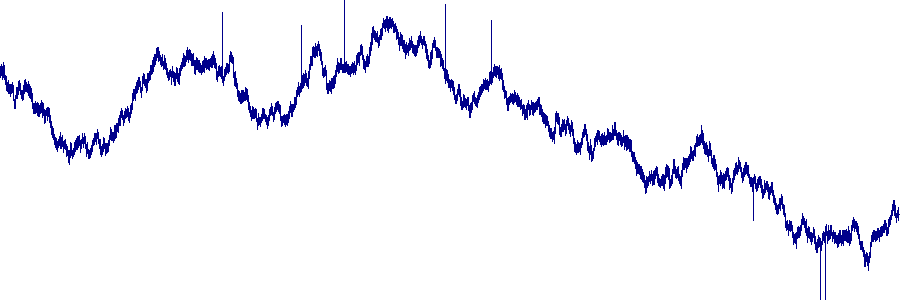

In [4]:
img

The result looks similar to what you might find in any plotting program, but it uses all 100,000 datapoints, and would work similarly for 1, 10, or 100 million points (determined by the `n` attribute above).  

Why is using all the datapoints important? To see, let's downsample the data by a factor of 10, plotting 10,000 datapoints for the same curve:

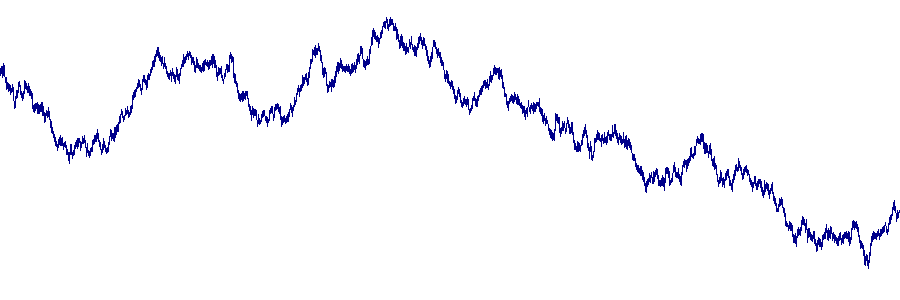

In [5]:
sampling = 10
df2 = pd.DataFrame({'a':data['a'][::sampling], 'Time':np.linspace(start, end, n/sampling)})
tf.shade(cvs.line(df2, 'Time', 'a'))

The resulting plot is similar, but now none of the "blown up" datapoints (sharp spikes) that were clearly visible in the first version are visible at all!  They didn't happen to be amongst the sampled points, and thus do not show up in this plot, which should never be a problem using datashader with all the points.


### Overplotting problems

What happens if we then overlay multiple such curves?  In a traditional plotting program, there would be serious issues with overplotting, because these curves are highly overlapping.  To show what would typically happen, let's merge the images corresponding to each of the curves:

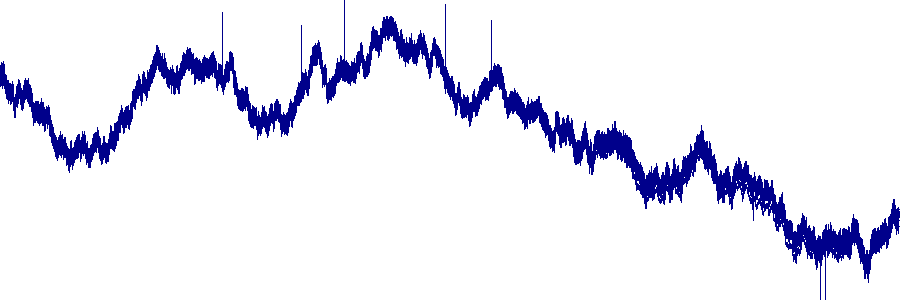

In [6]:
merged = xr.concat(aggs.values(), dim=pd.Index(cols, name='cols'))
tf.shade(merged.any(dim='cols'))

The `any` operator merges all the data such that any pixel that is lit up for any curve is lit up in the final result.  Clearly, it is difficult to see any structure in this fully overplotted data; all we can see is the envelope of these curves, i.e. the minimum and maximum value of any curve for any given time point. It remains completely unclear how the various curves in the set relate to each other.  Here we know that we put in one particularly noisy curve, which presumably determines the envelope, but there's no way to tell that from the plot.

We can of course try giving each curve a different color:

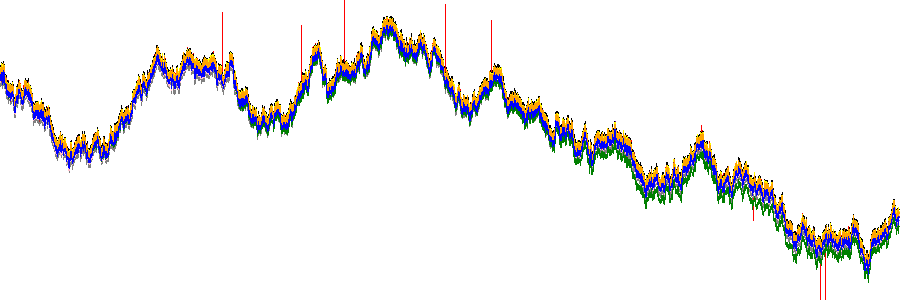

In [7]:
colors = ["red", "grey", "black", "purple", "pink",
          "yellow", "brown", "green", "orange", "blue"]
imgs = [tf.shade(aggs[i], cmap=[c]) for i, c in zip(cols, colors)]
tf.stack(*imgs)

But that doesn't help much; there are 10 curves, but only three or four colors are visible, due to overplotting.  Problems like that will just get much worse if there are 100, 1000, or 1 million curves.  Moreover, the results will look entirely different if we plot them in the opposite order:

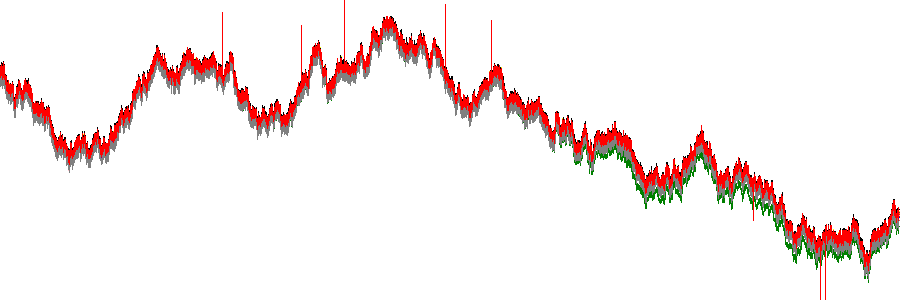

In [8]:
tf.stack(*reversed(imgs))

Having the visualization look completely different for an arbitrary choice like the plotting order is a serious problem if we want to understand the properties of this data, from the data itself.

### Trends and outliers

So, what might we be interested in understanding when plotting many curves?  One possibility is the combination of (a) the overall trends, and (b) any curves (and individual datapoints) that differ from those trends.  

To look at the trends, we should combine the plots not by overplotting as in each of the above examples, but using operators that accurately reveal overlap between the curves.  When doing so, we won't try to discern individual curves directly by assigning them unique colors, but instead try to show areas of the curves that establish the trends and differ from them.  (Assigning colors per curve could be done as for the racial categories in census.ipynb, but that won't be further investigated here.)

Instead of the `.any()` operator above that resulted in complete overplotting, or the `tf.stack` operator that depended strongly on the plotting order, let's use the `.sum()` operator to reveal the full patterns of overlap arithmetically:

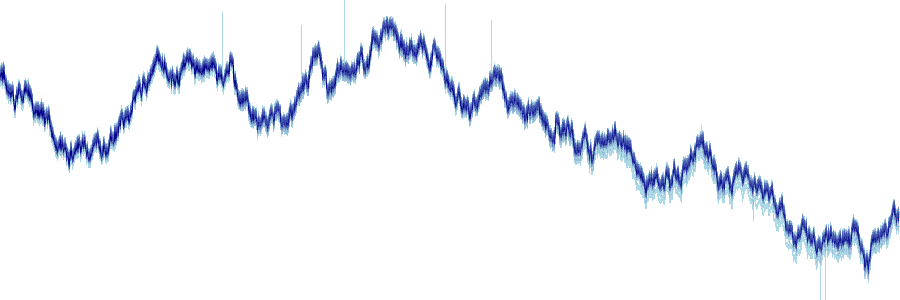

In [9]:
total = tf.shade(merged.sum(dim='cols'), how='linear')
total

With study, the overall structure of this dataset should be clear, according to what we know we put in when we created them:

1. Individual rogue datapoints from curve 'a' are clearly visible (the seven sharp spikes)
2. The trend is clearly visible (for the viridis colormap, the darkest greens show the areas of highest overlap)
3. Line 'x' that gradually diverges from the trend is clearly visible (as the light blue (low-count) areas that increase below the right half of the plot).

(Note that if you change the random seed or the number of datapoints, the specific values and locations will differ from those mentioned in the text.)

None of these observations would have been possible with downsampled, overplotted curves as would be typical of other plotting approaches.


### Highlighting specific curves

The data set also includes a couple of traces that are difficult to detect in the `.sum()` plot above, one with no noise and one with much higher noise.  One way to detect such issues is to highlight each of the curves in turn, and display it in relation to the datashaded average values.  For instance, those two curves (each highlighted in red below) stand out against the pack as having less or more noise than is typical:

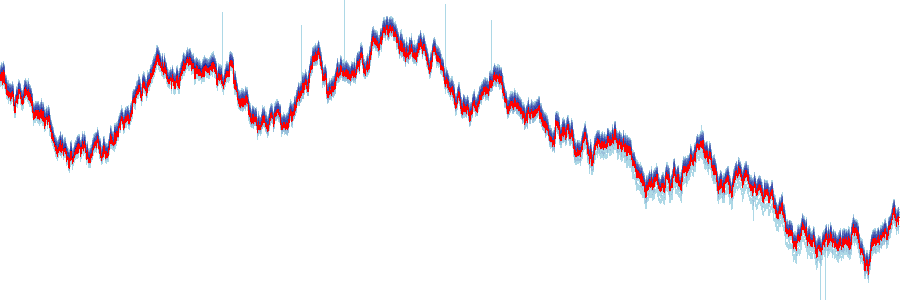

In [10]:
tf.stack(total, tf.shade(aggs['z'], cmap=["lightblue", "red"]))

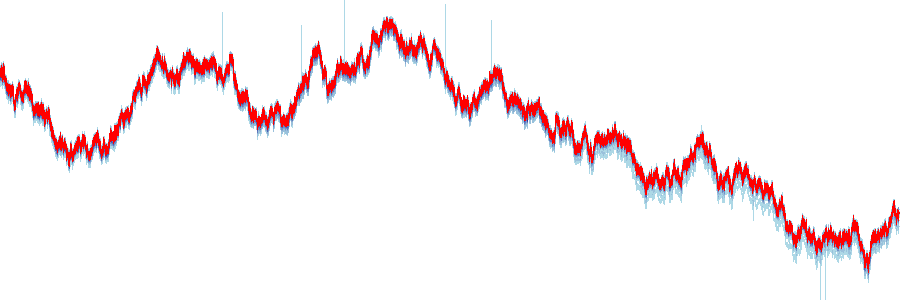

In [11]:
tf.stack(total, tf.shade(aggs['y'], cmap=["lightblue", "red"]))

### Dynamic Plots

In practice, it might be difficult to cycle through each of the curves to find one that's different, as done above.  Perhaps a criterion based on similarity could be devised, choosing the curve most dissimilar from the rest to plot in this way, which would be an interesting topic for future research.  In any case, one thing that can always be done is to make the plot fully interactive, so that the viewer can zoom in and discover such patterns dynamically.
If you are looking at a live, running version of this notebook, just enable the wheel zoom or box zoom tools, and then zoom and pan as you wish:

In [12]:
from bokeh.models import DatetimeTickFormatter
import bokeh.plotting as bp
bp.output_notebook()

formatter = DatetimeTickFormatter(formats = dict(
        microseconds=['%fus', '%H:%M %3fus', '%F %H:%M %3fus'],
        milliseconds=['%S.%3Ns', '%H:%M %3Nms', '%F %H:%M %3Nms'],
        seconds=['%Ss'],# '%H:%M:%S'],
        minsec=[':%M:%S', '%H:%M:%S'],
        hours=['%H:%M', '%F %H:%M'],
        days=['%F']))

def base_plot(tools='pan,wheel_zoom,box_zoom,resize,reset'):
    p = bp.figure(tools=tools, plot_width=600, plot_height=300,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, responsive=True)   
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.formatter = formatter
    return p

Loading BokehJS ...

In [13]:
from datashader.bokeh_ext import InteractiveImage
def create_image(x_range, y_range, w, h):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range,
                    plot_height=h, plot_width=w)
    aggs = OrderedDict((c,cvs.line(df, 'Time', c)) for c in cols)
    merged = xr.concat(aggs.values(), dim=pd.Index(cols, name='cols'))
    total = merged.sum(dim='cols')
    img = tf.shade(total, how='linear')
    return img
    
p = base_plot()
InteractiveImage(p, create_image)

Here the diverging "rogue line" is immediately apparent, and if you zoom in towards the right you can see precisely how it differs from the rest.  The low-noise "rogue line" is much harder to see, but if you zoom in enough (particularly if you stretch out the x axis by zooming on the axis itself), you can see that one line goes through the middle of the pack, with different properties from the rest.  The datashader team is working on support for hover-tool information to reveal what line that was, and in general on better support for exploring large timeseries (and other curve) data.

### Multiple trends

The above curves were very highly overlapping to illustrate a worst-case scenario, but now let's look at a case with curves that diverge more strongly from each other.   For instance, imagine that we have a simulation where one of three qualitatively different decisions are made at the starting time (perhaps three different parameter settings), along with noisy samples from each group, and we want to see what effect that has on the overall expected state into the future.  

Now, let's create time series in three different groups, each of which are similar to each other, but each group differing from each other as they diverge from a common starting point.  For instance, in a simulation run, each group could be from setting a different parameter, while each noisy version could be different runs with a different seed.

In [14]:
signals = [np.random.normal(0, 0.3, size=n).cumsum() + 50,
           np.random.normal(0, 0.3, size=n).cumsum() + 50,
           np.random.normal(0, 0.3, size=n).cumsum() + 50]
data = {c: signals[i%3] + noise(1+i, 5*(np.random.random() - 0.5), n)  for (i,c) in enumerate(cols)}
y_range = (1.2*min([s.min() for s in signals]), 1.2*max([s.max() for s in signals]))    

data['Time'] = np.linspace(start, end, n)
df = pd.DataFrame(data)

And let's examine the result interactively:

In [15]:
def create_image3(x_range, y_range, w, h, df=df):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range,
                    plot_height=h, plot_width=w)
    aggs = [cvs.line(df, 'Time', c) for c in cols]
    merged = xr.concat(aggs, dim=pd.Index(cols, name='cols'))
    total = merged.sum(dim='cols')
    image = tf.shade(total, how='linear')
    return image

p2 = base_plot()
InteractiveImage(p2, create_image3,df=df)

Here the three groups can clearly be seen, at least once they diverge sufficiently, as well as the areas of high overlap (high probability of being in that state at that time).  Additional patterns are visible when zooming in, all the way down to the individual datapoints, and again it may be useful to zoom first on the x axis (to make enough room on your screen to distinguish the datapoints, since there are 100,000 of them and only a few thousand pixels at most on your screen!). And note again that the interactive plots require a running server if you want to see more datapoints as you zoom in; static exports of this notebook won't support full zooming.